In [1]:
#imports
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy import integrate

import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, Parameter, report_fit
from sklearn.metrics import r2_score
import random

In [2]:
#for getting yield/rate graphs
def change_coord(data, init, timespan):
    yield_list_E = []
    yield_list_A1 = []
    yield_list_A2 = []
    yield_list_tE = []
    for i in range(len(data[0])):
        yield_list_E.append((data[0][i])/init[0])
        yield_list_A1.append((data[1][i])/init[0])
        yield_list_A2.append((data[2][i])/init[0])
        yield_list_tE.append((data[3][i])/init[0])
    yield_lists = [yield_list_E,yield_list_A1,yield_list_A2,yield_list_tE]

    rate_list_E = []
    rate_list_A1 = []
    rate_list_A2 = []
    rate_list_tE = []
    for i in range(len(data[0])-1):
        rate_list_E.append((data[0][i+1]-data[0][i])/(timespan[i+1]-timespan[i]))
        rate_list_A1.append((data[1][i+1]-data[1][i])/(timespan[i+1]-timespan[i]))
        rate_list_A2.append((data[2][i+1]-data[2][i])/(timespan[i+1]-timespan[i]))
        rate_list_tE.append((data[3][i+1]-data[3][i])/(timespan[i+1]-timespan[i]))
    rate_lists = [rate_list_E,rate_list_A1,rate_list_A2,rate_list_tE]

    return yield_lists, rate_lists

In [3]:
# 74 = 98, 72 = 11, 71 = 121

In [4]:
#get the data
data = pd.read_excel('second_reactor_run.xls')

In [5]:
#check
data

,Time,Tags500-.Tag 57,Tags500-.Tag 58,Tags500-.Tag 59,Tags500-.Tag 60,Tags500-.Tag 61,time,r1,r2,r3,r4,r6,time.1,r1.1,r2.1,r3.1,r4.1,r6.1
0,2022-01-26 17:08:00,49.93,49.62,48.33,51.39,51.01,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2022-01-26 17:08:10,49.52,49.53,48.30,51.23,51.00,0.166667,0.41,0.09,0.03,0.16,0.01,0.166667,0.077870,0.017093,0.005698,0.030388,0.001899
2,2022-01-26 17:08:20,49.51,49.54,48.29,51.19,50.98,0.333333,0.42,0.08,0.04,0.20,0.03,0.333333,0.079769,0.015194,0.007597,0.037985,0.005698
3,2022-01-26 17:08:30,49.48,49.52,48.30,51.16,50.94,0.500000,0.45,0.10,0.03,0.23,0.07,0.500000,0.085467,0.018993,0.005698,0.043683,0.013295
4,2022-01-26 17:08:40,49.48,49.52,48.27,51.16,50.94,0.666667,0.45,0.10,0.06,0.23,0.07,0.666667,0.085467,0.018993,0.011396,0.043683,0.013295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15281,2022-01-28 11:35:00,41.38,NaN,NaN,NaN,NaN,2547.000000,8.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15282,2022-01-28 11:35:10,41.38,NaN,NaN,NaN,NaN,2547.166667,8.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15283,2022-01-28 11:35:20,41.39,NaN,NaN,NaN,NaN,2547.333333,8.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15284,2022-01-28 11:35:30,41.36,NaN,NaN,NaN,NaN,2547.500000,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
#clean the data
first = data.iloc[1:2,12:18]
convs = data.iloc[::10,12:18]
convs = convs.iloc[1:,:]
convs = pd.concat([first, convs], axis = 0)

In [33]:
# convs = data.iloc[1:,12:18]

In [34]:
convs

,time.1,r1.1,r2.1,r3.1,r4.1,r6.1
1,0.166667,0.077870,0.017093,0.005698,0.030388,0.001899
10,1.666667,0.098762,0.034187,0.034187,0.068374,0.030388
20,3.333333,0.094963,0.036086,0.062676,0.119654,0.041784
30,5.000000,0.098762,0.047482,0.094963,0.203222,0.036086
40,6.666667,0.113956,0.072172,0.182330,0.254502,0.043683
...,...,...,...,...,...,...
15240,NaN,NaN,NaN,NaN,NaN,NaN
15250,NaN,NaN,NaN,NaN,NaN,NaN
15260,NaN,NaN,NaN,NaN,NaN,NaN
15270,NaN,NaN,NaN,NaN,NaN,NaN


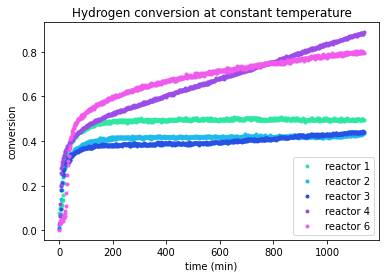

In [36]:
#check plot
plt.figure()
plt.scatter(convs.iloc[:,0],convs.iloc[:,1], label = 'reactor 1', s = 9,color = '#2DE8A0')
plt.scatter(convs.iloc[:,0],convs.iloc[:,2], label = 'reactor 2', s = 9,color = '#1EBAEE')
plt.scatter(convs.iloc[:,0],convs.iloc[:,3], label = 'reactor 3', s = 9, color = '#2652E3')
plt.scatter(convs.iloc[:,0],convs.iloc[:,4], label = 'reactor 4', s = 9, color = '#9C4CE8')
plt.scatter(convs.iloc[:,0],convs.iloc[:,5], label = 'reactor 6', s = 9, color = '#F05BEE')
plt.title('Hydrogen conversion at constant temperature')
plt.xlabel('time (min)')
plt.ylabel('conversion')
plt.legend()
plt.savefig("C:/Users/natha/OneDrive/Documenten/uni/uni documenten/MEP/MEP_figures/paper/second-real_run.svg",dpi=300)

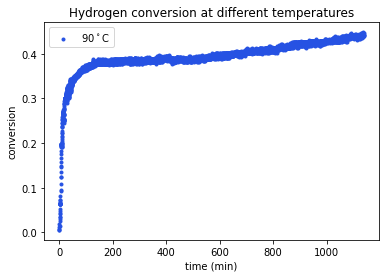

In [25]:
plt.scatter(convs.iloc[:,0],convs.iloc[:,3], label = '90$^\circ$C', s = 9, color = '#2652E3')
plt.title('Hydrogen conversion at different temperatures')
plt.xlabel('time (min)')
plt.ylabel('conversion')
plt.legend()
# plt.savefig("C:/Users/natha/OneDrive/Documenten/uni/uni documenten/MEP/MEP_figures/paper/single_real_run.svg",dpi=300)

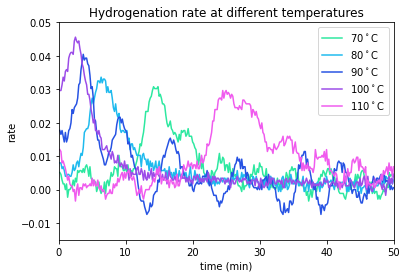

In [28]:
#plot rate graph
def conv_real(data):    
    rate_list = []
    data  = list(data)
    for i in range(len(data)-20):
            rate_list.append((data[i+20]-data[i])/(list(convs.iloc[:,0])[i+20]-(list(convs.iloc[:,0])[i])))
    return np.array(rate_list)
plt.plot(convs.iloc[:,0][:-20],conv_real(convs.iloc[:,1]),color = '#2DE8A0',label = '1')
plt.plot(convs.iloc[:,0][:-20],conv_real(convs.iloc[:,2]),color = '#1EBAEE',label = '2')
plt.plot(convs.iloc[:,0][:-20],conv_real(convs.iloc[:,3]),color = '#2652E3',label = '3')
plt.plot(convs.iloc[:,0][:-20],conv_real(convs.iloc[:,4]),color = '#9C4CE8',label = '4')
plt.plot(convs.iloc[:,0][:-20],conv_real(convs.iloc[:,5]),color = '#F05BEE',label = '6')
plt.title('Hydrogenation rate at different temperatures')
plt.xlabel('time (min)')
plt.ylabel('rate')
plt.xlim([0,50])
plt.ylim([-0.015,0.05])
plt.legend()
# plt.savefig("C:/Users/natha/OneDrive/Documenten/uni/uni documenten/MEP/MEP_figures/paper/real_rates_varied.svg",dpi=300)